# Predict low high models
Model selection for predict lo hi


To install conda and binance packages to this notebook uncomment the code below

In [1]:
%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
%pip install plotly==5.9.0
%pip install twisted
#%pip install binance-connector==1.13.0
%pip install pandas
%pip install scikit-learn
%pip install tensorflow==2.11.0
%pip install keras==2.11.0
%pip install scikeras
%pip install keras-tuner

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

## Feature engineering
Read data from bot's history, resample to equal intervals, create X, y

### Read data from bot's history

In [2]:
import os
import glob
import pandas as pd
from datetime import timedelta,date

def read_last_data(strategy, days=1, n=None):
    """ Read last last day from bot history """
    
    def read_last(symbol: str, name: str, days=1):
        data_dir=f"./../data/yandex-cloud/{strategy}/Xy"
        file_paths = sorted([f"{data_dir}/{f}" for f in os.listdir(data_dir) if f.endswith(f"{symbol}_{name}.csv")])[-days:]
        print(file_paths)
        return pd.concat([pd.read_csv(f, parse_dates=True, index_col="datetime") for f in file_paths])

    data=read_last("BTCUSDT", "data", days)
    X=read_last("BTCUSDT", "X", days)
    y=read_last("BTCUSDT", "y", days)
    if n: 
        data=data.tail(n)
        X=X.tail(n)
        y=y.tail(n)
    return data,X,y

#strategy="SimpleKerasStrategy"
strategy="LSTMStrategy"
bidask,X_bot,y_bot = read_last_data(strategy, days=2, n=1000000)
print(f"Raw data len: {len(X_bot)}")


['./../data/yandex-cloud/LSTMStrategy/Xy/2023-05-24_BTCUSDT_data.csv', './../data/yandex-cloud/LSTMStrategy/Xy/2023-05-25_BTCUSDT_data.csv']
['./../data/yandex-cloud/LSTMStrategy/Xy/2023-05-24_BTCUSDT_X.csv', './../data/yandex-cloud/LSTMStrategy/Xy/2023-05-25_BTCUSDT_X.csv']
['./../data/yandex-cloud/LSTMStrategy/Xy/2023-05-24_BTCUSDT_y.csv', './../data/yandex-cloud/LSTMStrategy/Xy/2023-05-25_BTCUSDT_y.csv']
Raw data len: 90463


### Resample data to use equal time intervals

In [3]:
import re
def get_targets(bidask, predict_window="10s"):
    """ 
    Calculate targets - bid/ask bounds in future prediction window
    """
    fut_min=bidask[["bid", "ask"]][::-1].rolling(predict_window).min()[::-1].rename(columns={"bid":"bid_min_fut", "ask":"ask_min_fut"})
    fut_max=bidask[["bid", "ask"]][::-1].rolling(predict_window).max()[::-1].rename(columns={"bid":"bid_max_fut", "ask":"ask_max_fut"})
    return pd.concat([fut_min, fut_max], axis = 1)
    
def resampled(X: pd.DataFrame, y: pd.DataFrame, time_interval) -> (pd.DataFrame, pd.DataFrame):
    """ Resample to make equal intervals time series """
    if int(re.sub(r'\D', "", time_interval)) == 0:
        return X, y
    Xy=pd.concat([X,y], axis=1)
    diffmap = [(c, "sum") for c in Xy.columns if c.endswith("diff")]
    timemap = [(c, "last") for c in Xy.columns if c.startswith("time") and not c.endswith("diff")]
    l2map = [(c, "last") for c in Xy.columns if c.startswith("l2_")]
    candlemap = [(c,"last") for c in Xy.columns \
                 if c.endswith("_open") or c.endswith("_high") or c.endswith("_low") or c.endswith("_close") or c.endswith("_vol")]
    
    futmap = [(c, "last") for c in Xy.columns if c.endswith("_fut")]
    colmap = dict(diffmap + timemap + l2map + futmap + [("spread", "last")] + candlemap)
    resampled = Xy.resample(time_interval).agg(colmap).dropna()
    return resampled[X.columns], resampled[y.columns]

predict_window="60s"
resample_interval="10s"
y_raw = get_targets(bidask, predict_window)
X,y=X_bot,y_raw
#X,y = resampled(X_bot, y_raw, resample_interval)
print(f"Data len: {len(X)}")


Data len: 90463


### Train test split

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scikeras.wrappers import KerasRegressor
from keras.layers import *
from keras.layers import LSTM
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner

def train_test_split(X,y):
    test_size=0.3
    test_index = int(len(X)*(1-test_size))
    X_train, y_train, X_test, y_test = X.iloc[:test_index], y.iloc[:test_index], X.iloc[test_index:], y.iloc[test_index:]
    time_cols=[col for col in X.columns if col.startswith("time")]
    float_cols = list(set(X.columns)-set(time_cols))

    # Train/test split    
#     x_scaler = 

    x_scaler = ColumnTransformer([("xrs",RobustScaler(), float_cols)], remainder="passthrough")

    x_pipe = Pipeline(
        [("xscaler", ColumnTransformer([("xrs",RobustScaler(), float_cols)], remainder="passthrough")),
         ("xmms",MinMaxScaler())])

    
    x_pipe.fit(X_train)

    y_pipe = Pipeline(
        [("yrs", RobustScaler()),
         ("ymms",MinMaxScaler())])
    y_pipe.fit(y_train)

    #x_scaler, y_scaler = MinMaxScaler().fit(X_train), MinMaxScaler().fit(y_train)
    X_train, y_train = x_pipe.transform(X_train), y_pipe.transform(y_train)
    X_test, y_test = x_pipe.transform(X_test), y_pipe.transform(y_test)
    print(f"Train size: {X_train.shape[0]}, test size: {X_test.shape[0]}")
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split(X, y)
print(X_train.shape)

2023-05-25 04:22:33.614010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 04:22:33.728693: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-25 04:22:33.728716: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-25 04:22:34.252816: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Train size: 63324, test size: 27139
(63324, 80)


## Model tuning


In [5]:
%%capture
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scikeras.wrappers import KerasRegressor
from keras.layers import *
from keras.layers import LSTM
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner

In [6]:
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scikeras.wrappers import KerasRegressor
from keras.layers import *
from keras.layers import LSTM
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner




def create_tuner_model(hp):
    """ Create model for tuner. Expects X_train, y_train, window_size"""
    model = Sequential()
    hp_lstm1_units=hp.Int("lstm1_units", min_value=4, max_value=1000)
    hp_lstm1_dropout=hp.Float("lstm1_dropout", min_value=0, max_value=0.3)

#     column_num=X_train.shape[1]
#     window_sizes=[1,5,10,50] 
#     hp_window_size=hp.Choice("window_size", window_sizes)
    model.add(LSTM(hp_lstm1_units,
                   return_sequences=True, input_shape=(window_size, X_train.shape[1])))
#     model.add(LSTM(hp_input_units,
#                    return_sequences=True, input_shape=(hp_window_size, column_num)))

    model.add(Dropout(hp_lstm1_dropout))
    
    hp_lstm2_units=hp.Int("lstm2_units", min_value=4, max_value=1000)
    hp_lstm2_dropout=hp.Float("lstm2_dropout", min_value=0, max_value=0.3)
    model.add(LSTM(hp_lstm2_units))         
    model.add(Dropout(hp_lstm2_dropout))

    hp_dense1_units=hp.Int("dense1_units", min_value=4, max_value=1000)
    hp_dense1_dropout=hp.Float("dense1_dropout", min_value=0, max_value=0.3)
    model.add(Dense(hp_dense1_units, activation='relu'))
    model.add(Dropout(hp_dense1_dropout))

    hp_dense2_units=hp.Int("dense2_units", min_value=4, max_value=100)
    hp_dense2_dropout=hp.Float("dense2_dropout", min_value=0, max_value=0.3)
    model.add(Dense(hp_dense2_units, activation='relu'))
    model.add(Dropout(hp_dense2_dropout))
    
    model.add(Dense(y_train.shape[1], activation='linear'))
    model.compile(optimizer='adam', loss='mae', metrics=['mse'])
    return model
    
window_size = 10

def create_tuner(max_trials):
    # Tune the model
    # tuner=keras_tuner.Hyperband(
    #     hypermodel=create_tuner_model,
    #     objective="val_mse",
    #     max_epochs=5,
    #     factor=3,
    #     hyperband_iterations=1,
    #     seed=None,
    #     hyperparameters=None,
    #     tune_new_entries=True,
    #     allow_new_entries=True,
    #     max_retries_per_trial=0,
    #     max_consecutive_failed_trials=3
    # )
    tuner=keras_tuner.BayesianOptimization(
        hypermodel=create_tuner_model,
        objective="val_mse",
        max_trials=max_trials,
        num_initial_points=None,
        alpha=0.0001,
        beta=2.6,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        max_retries_per_trial=0,
        max_consecutive_failed_trials=3,
        overwrite=True,
        directory=f"./tmp/{strategy}/tune",
        project_name="pytrade2",    
    )
    # tuner = keras_tuner.RandomSearch(
    #     hypermodel=create_tuner_model,
    #     objective="val_mse",
    #     max_trials=3,
    #     executions_per_trial=2,
    #     overwrite=True,
    #     directory=f"./tmp/{strategy}/tune",
    #     project_name="pytrade2",
    #     )
    tuner.search_space_summary()
    return tuner

def tuner_search(max_trials,train_gen, test_gen):
    tuner = create_tuner(max_trials)
    tuner.search(train_gen,epochs=5, validation_data=test_gen)
    return tuner

train_gen = TimeseriesGenerator(X_train, y_train, length=window_size)
test_gen = TimeseriesGenerator(X_test, y_test, length=window_size)
# Uncomment to do optimize
tuner = tuner_search(1, train_gen, test_gen)





Trial 1 Complete [00h 04m 27s]
val_mse: 0.07053039222955704

Best val_mse So Far: 0.07053039222955704
Total elapsed time: 00h 04m 27s
INFO:tensorflow:Oracle triggered exit


In [7]:
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "1")

tuner.results_summary()
models=tuner.get_best_models(5)
for model in models:
    model.summary()



Results summary
Results in ./tmp/LSTMStrategy/tune/pytrade2
Showing 10 best trials
Objective(name="val_mse", direction="min")

Trial 0 summary
Hyperparameters:
lstm1_units: 287
lstm1_dropout: 0.21246648368001278
lstm2_units: 690
lstm2_dropout: 0.014994150094578473
dense1_units: 691
dense1_dropout: 0.22176010626956516
dense2_units: 39
dense2_dropout: 0.2257262191541618
Score: 0.07053039222955704
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 287)           422464    
                                                                 
 dropout (Dropout)           (None, 10, 287)           0         
                                                                 
 lstm_1 (LSTM)               (None, 690)               2699280   
                                                                 
 dropout_1 (Dropout)         (None, 690)              

## Model evaluation

Creating model([482, 0.2, 800, 0.13, 590, 0.29, 49, 0.22]), input shape=(10, 80)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 482)           1085464   
                                                                 
 dropout_4 (Dropout)         (None, 10, 482)           0         
                                                                 
 lstm_3 (LSTM)               (None, 800)               4105600   
                                                                 
 dropout_5 (Dropout)         (None, 800)               0         
                                                                 
 dense_3 (Dense)             (None, 590)               472590    
                                                                 
 dropout_6 (Dropout)         (None, 590)               0         
                                       

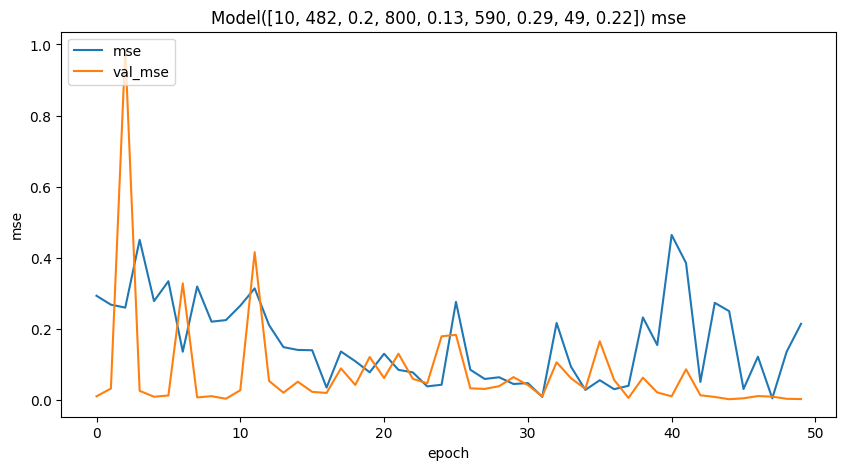

In [8]:
import collections

# def create_model_prod(X_train, y_train, window_size):
#     model = Sequential()
#     model.add(LSTM(128,  return_sequences=True, input_shape=(window_size, X_train.shape[1])))
#     model.add(Dropout(0.2))
#     model.add(LSTM(32))         
#     model.add(Dropout(0.2))
#     model.add(Dense(20, activation='relu'))
#     model.add(Dense(y_train.shape[1], activation='linear'))
#     #model.add(Dense(y_train.shape[1], activation='softmax'))
#     model.compile(optimizer='adam', loss='mae', metrics=['mse'])
#     return model  
plot_figsize=(10,5)
#def create_model(X_train, y_train, window_size, lstm1_units, lstm2_units, dense1_units, dense2_units):
def create_model(X_train,  y_train, window_size, specs):

    # 1200, 132, 44
    # 800, 800, 64
    input_shape=(window_size, X_train.shape[1])
    print(f"Creating model({specs}), input shape={input_shape}")

    model = Sequential()
    
    model.add(LSTM(specs[0],  return_sequences=True, input_shape=input_shape))
    model.add(Dropout(specs[1]))
    model.add(LSTM(specs[2]))         
    model.add(Dropout(specs[3]))
    model.add(Dense(specs[4], activation='relu'))
    model.add(Dropout(specs[5]))
    model.add(Dense(specs[6], activation='relu'))
    model.add(Dropout(specs[7]))
    model.add(Dense(y_train.shape[1], activation='linear')) # linear for regression

    model.compile(optimizer='adam', loss='mae', metrics=['mse'])
    model.summary()
    return model


def plot_history(model_name, history, metric=None):
    """ Plot history loss and metrics"""
    metric_names = [metric] if metric else history.history
    
    # Print all merrics
    for metric_name in metric_names:
        # Validation metrics names will be calculated from related train metrics
        if metric_name.startswith("val_"): continue

        # Plot metric and related test (val_..) metric
        plt.figure(figsize=plot_figsize)
        names=[metric_name, f"val_{metric_name}"]
        for name in names:
            plt.plot(history.history[name])
        # Captions and show the plot
        plt.title(f"{model_name} {metric_name}")
        plt.ylabel(metric_name)
        plt.xlabel('epoch')
        plt.legend(names, loc='upper left')
        plt.show()

def fit_model(model, train_gen, test_gen):
    # Fit the model
    epochs=50
    steps_per_epoch=5
    history=model.fit(train_gen, validation_data=test_gen, epochs=epochs, steps_per_epoch=steps_per_epoch)
    return history


def evaluate_models(*specs):
    results={}
    for unit_spec in specs:
        #print(unit_spec)
        window_size=unit_spec[0]
        model = create_model(X_train, y_train, window_size, unit_spec[1:])
        
        train_gen = TimeseriesGenerator(X_train, y_train, length=window_size)
        test_gen = TimeseriesGenerator(X_test, y_test, length=window_size)        
        history = fit_model(model, train_gen, test_gen)
        
        model_name = f"Model({unit_spec})"
        results[model_name] = history
    return results

def plot_res(results):
    for model_name in results:
        plot_history(model_name, results[model_name], "mse")

    
# Good: 80, 512, 20
base_model_res = evaluate_models([10,482,0.2,800, 0.13, 590, 0.29, 49, 0.22])
plot_res(base_model_res)


Creating model([320, 0.2, 160, 0.2, 40, 0.2, 16, 0.1]), input shape=(10, 80)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 320)           513280    
                                                                 
 dropout_8 (Dropout)         (None, 10, 320)           0         
                                                                 
 lstm_5 (LSTM)               (None, 160)               307840    
                                                                 
 dropout_9 (Dropout)         (None, 160)               0         
                                                                 
 dense_6 (Dense)             (None, 40)                6440      
                                                                 
 dropout_10 (Dropout)        (None, 40)                0         
                                           

Creating model([825, 0.1, 588, 0.2, 190, 0.1, 59, 0.2]), input shape=(10, 80)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 825)           2989800   
                                                                 
 dropout_12 (Dropout)        (None, 10, 825)           0         
                                                                 
 lstm_7 (LSTM)               (None, 588)               3325728   
                                                                 
 dropout_13 (Dropout)        (None, 588)               0         
                                                                 
 dense_9 (Dense)             (None, 190)               111910    
                                                                 
 dropout_14 (Dropout)        (None, 190)               0         
                                          

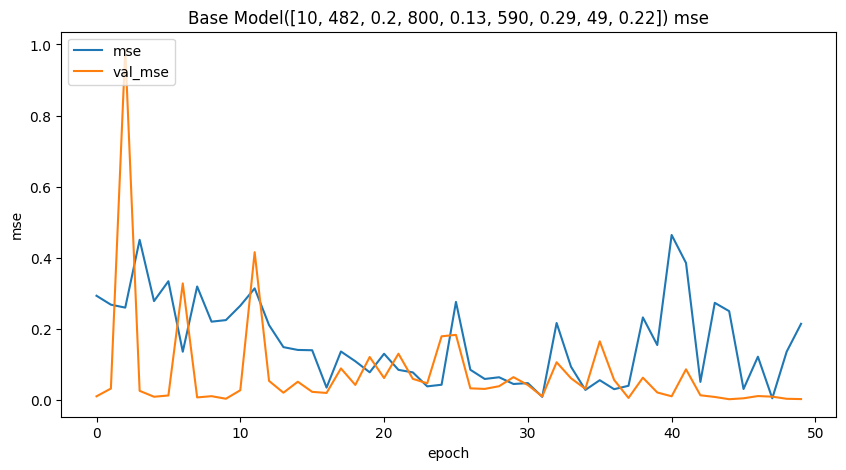

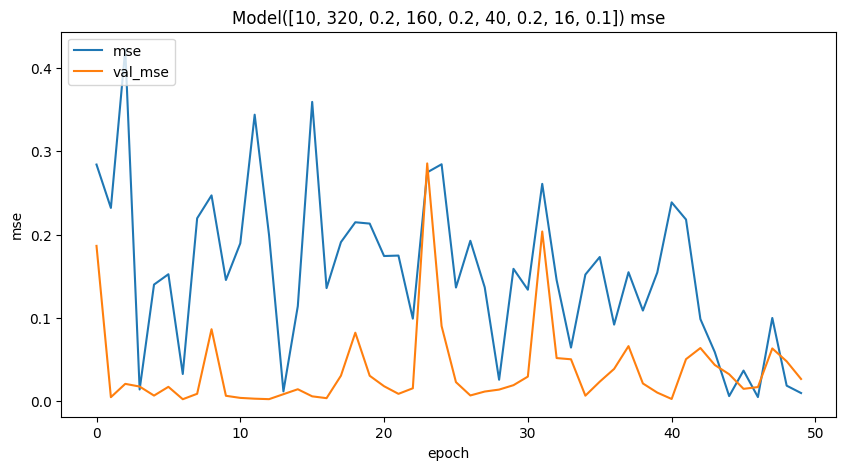

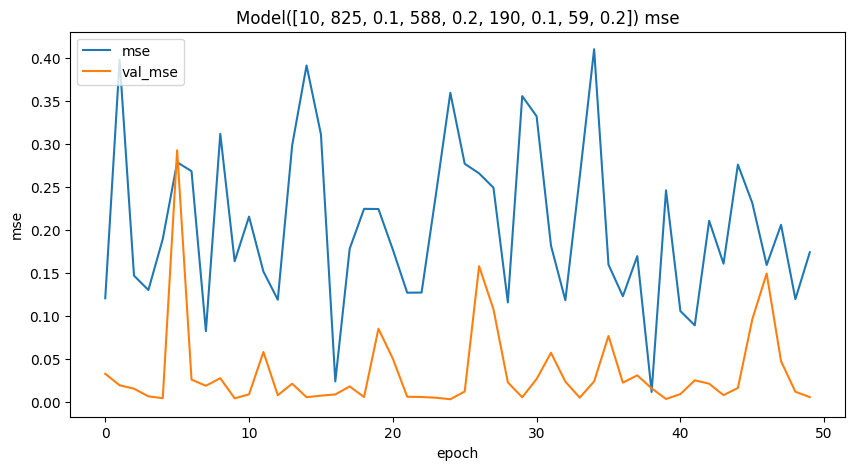

In [9]:
# Good models:
#new_res = evaluate_models([10,320,0.2,160, 0.2, 40, 0.2, 16, 0.1])

new_res = evaluate_models([10,320,0.2,160, 0.2, 40, 0.2, 16, 0.1], 
                          [10,825,0.1,588, 0.2, 190, 0.1, 59, 0.2])
# Add previous base model to comparison
res = {f"Base {key}":val for key,val in base_model_res.items()}
res.update(new_res)

plot_res(res)
